# はじめに
## 本ノートブックの目的
機械学習モデルの複数の出力に対して、逆解析していくアルゴリズムを実装する必要があった。

## 本ノートブックの概要
KerasのFunctional APIを用いて複数出力の深層学習モデルを作成 → 出力の所望値を定数で定義 → 出力の所望値と学習済みモデルの出力との二乗誤差を取った式をそれぞれ目的関数として設定 → 多目的最適化アルゴリズムであるNSGA-IIで有用な入力パラメータを探索する仕組みを構築。

## 処理フロー
1. 使用するライブラリをインポート
2. データの読み込み・確認
3. データ分割
4. KerasのFunctional APIで学習
5. 学習後の精度評価
6. NSGA-Ⅱ実装

## 1. 使用するライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.models import Model
from keras.layers import Input, Dense

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

## 2. データの読み込み・確認

In [2]:
# GCPのAPIキーの取得
from google.colab import auth
auth.authenticate_user()

In [3]:
# プロジェクトの定義
project_id='dpnc-first'
# 発行するSELECT分を定義
sql='''
select
  *
from
  `dpnc-first.dataset_table.first_table`
'''

# SELECT文の実行
df=pd.io.gbq.read_gbq(sql, project_id=project_id)

In [4]:
# データフレーム確認
df = df[df['BandGap1'] >= 0]  # BandGapがないデータは消去
df

,C_back,rho_back,C_center,rho_center,f,w1_max,BandGap1,w2_max,BandGap2,w3_max,...,w5_max,BandGap5,w6_max,BandGap6,w7_max,BandGap7,w8_max,BandGap8,w9_max,BandGap9
35,1.0,1.0,2.90,1.85,0.25,0.612391,0.003893,0.978904,-0.138977,1.182337,...,1.620940,-0.384707,1.624912,-0.271613,1.637103,-0.121339,1.735088,-0.142617,1.866405,-0.166642
36,1.0,1.0,2.90,1.90,0.25,0.606353,0.009264,0.974253,-0.136260,1.179924,...,1.615231,-0.387084,1.616727,-0.268883,1.630751,-0.118519,1.728563,-0.139728,1.861417,-0.164749
37,1.0,1.0,2.90,1.95,0.25,0.600485,0.014462,0.969729,-0.133676,1.177460,...,1.607564,-0.387412,1.608070,-0.265500,1.627751,-0.118885,1.722195,-0.137050,1.856385,-0.162845
38,1.0,1.0,2.90,2.00,0.25,0.594779,0.019497,0.965327,-0.131222,1.174875,...,1.599027,-0.386764,1.599104,-0.260835,1.627019,-0.121367,1.716005,-0.134602,1.849958,-0.159610
39,1.0,1.0,2.90,2.05,0.25,0.589227,0.024374,0.961043,-0.128891,1.171624,...,1.589964,-0.382471,1.590101,-0.255718,1.626513,-0.123935,1.710003,-0.132394,1.845201,-0.158113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64901,1.0,1.0,2.65,0.15,0.65,1.056115,0.008320,1.644760,-0.266026,1.728519,...,2.386829,-0.102326,2.777673,-0.163194,3.260757,-0.629545,3.272518,-0.055087,3.548610,-0.260507
64959,1.0,1.0,2.65,0.10,0.90,1.444950,0.551949,2.595674,-0.215398,2.633493,...,4.428731,0.001387,5.127353,-0.234609,5.579055,0.338132,6.508305,-0.591118,6.536474,-0.188880
64960,1.0,1.0,2.65,0.15,0.90,1.426274,0.336386,2.345375,-0.122915,2.556799,...,4.045148,-0.018579,4.660704,-0.313035,4.851775,0.040707,5.681703,-0.789221,5.775893,0.421212
64961,1.0,1.0,2.65,0.20,0.90,1.407567,0.171762,2.170197,-0.098696,2.481779,...,3.676785,-0.012223,4.245927,-0.273402,4.390310,-0.097979,5.102538,-0.810207,5.235687,0.121770


## 3. データ分割

In [5]:
# データの分割
(train, test) = train_test_split(df, test_size=0.2, shuffle=True)

In [6]:
# x_train, x_testではcsvファイルの1〜5列目を， y_train, y_testでは6〜7列目のデータを活用
x_train = train.iloc[:, 2:5]
y_train = train.iloc[:, 5:7]

x_test = test.iloc[:, 2:5]
y_test = test.iloc[:, 5:7]

## 4. KerasのFunctional APIで学習
### モデルの概要
- 入力層：2ノード(C2, s)
- 中間層：3層, 各層64ノード
    - アウトプット直前の層にプラスで1層
- 出力層：2ノード（w11_max, BandGap1）

### 活性化関数
- ReLUを採用（勾配消失問題の解消, 処理速度が速い, 多くの場合高い性能を示す）

### 損失関数
- 回帰問題に適したMSE（平均二乗誤差）を採用

### 最適化アルゴリズム
- Adamを採用（Kingma氏らが2014年に提案した高い性能を示すことで知られている | 参考：[Adam: A Method for Stochastic Optimization](https://www.semanticscholar.org/paper/Adam%3A-A-Method-for-Stochastic-Optimization-Kingma-Ba/a6cb366736791bcccc5c8639de5a8f9636bf87e8)）
  - ハイパーパラメータは提案論文の推奨値で決定
    - lr：学習率
    - beta_1：過去の勾配の指数移動平均を計算する際の減衰係数
    - beta_2：過去の勾配の二乗の指数移動平均を計算する際の減衰係数

### その他ハイパーパラメータ
- 学習回数：300回
- バッチサイズ：64

### アウトプット記事
- https://sgs-prog.com/keras-multiple-outputs/

In [8]:
# モデルの構築
# inputの数:3（C_center, rho_center, f）
inputs = Input(shape=(3,))

# 学習回数
epochs = 300
batch_size = 64

# ノード数
node = 64

x1 = Dense(node, activation='relu')(inputs)
x2 = Dense(node, activation='relu')(x1)
x3 = Dense(node, activation='relu')(x2)


x4 = Dense(node, activation='relu')(x3) # アウトプット直前の層
output1 = Dense(1, name='output1')(x4)

x5 = Dense(node, activation='relu')(x3) # アウトプット直前の層
output2 = Dense(1, name='output2')(x5)

model = Model(inputs=inputs, outputs=[output1, output2])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss=['mse', 'mse']
)

In [9]:
# 学習オプション
history = model.fit(x_train,
                    {"output1":y_train.iloc[:, [0]], "output2":y_train.iloc[:, [1]]},
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_test, {"output1":y_test.iloc[:, [0]], "output2":y_test.iloc[:, [1]]})
)

Epoch 1/300
90/90 [==============================] - 3s 8ms/step - loss: 0.0392 - output1_loss: 0.0326 - output2_loss: 0.0066 - val_loss: 0.0065 - val_output1_loss: 0.0025 - val_output2_loss: 0.0040
Epoch 2/300
90/90 [==============================] - 0s 3ms/step - loss: 0.0058 - output1_loss: 0.0022 - output2_loss: 0.0037 - val_loss: 0.0051 - val_output1_loss: 0.0019 - val_output2_loss: 0.0032
Epoch 3/300
90/90 [==============================] - 0s 3ms/step - loss: 0.0039 - output1_loss: 0.0017 - output2_loss: 0.0021 - val_loss: 0.0029 - val_output1_loss: 0.0016 - val_output2_loss: 0.0013
Epoch 4/300
90/90 [==============================] - 0s 3ms/step - loss: 0.0023 - output1_loss: 0.0012 - output2_loss: 0.0010 - val_loss: 0.0017 - val_output1_loss: 0.0010 - val_output2_loss: 6.3293e-04
Epoch 5/300
90/90 [==============================] - 0s 3ms/step - loss: 0.0016 - output1_loss: 8.9970e-04 - output2_loss: 6.8953e-04 - val_loss: 0.0015 - val_output1_loss: 9.1570e-04 - val_output2_lo

In [10]:
# 構築したモデルで予測
pred1, pred2 = model.predict(x_test)

45/45 [==============================] - 0s 1ms/step


## 5. 学習後の精度評価

## 精度評価指標
### MAE（Mean Absolute Error | 平均絶対誤差）
- 各データに対して「予測値と正解値の差(=誤差)」の絶対値を計算し、その総和をデータ数で割った値(=平均値)を出力する関数。0に近いほど良い。

### RMSE（Root Mean Squared Error | 二乗平均平方根誤差）
- 各データに対して「予測値と正解値の差(=誤差)」の二乗値を計算し, その総和をデータ数で割った値(=平均値)の平方根をとって出力する関数。0に近いほど良い。

### 決定係数（Coefficient of Determination | R^2）
- 出力の実測値と出力の予測値の間の相関係数を表す。1に近づくをほど良い。

参考：https://funatsu-lab.github.io/open-course-ware/basic-theory/accuracy-index/

In [11]:
#精度評価指標
# Output1 ====================================================================
print("=======  Output1  =======")
# MAE
test_MAE = mean_absolute_error(y_test.iloc[:, 0], pred1)
print('MAE：', test_MAE)

# RMSE
test_RMSE = sqrt(mean_squared_error(y_test.iloc[:, 0], pred1))
print('RMSE：', test_RMSE)

# 決定係数
R2 = r2_score(y_test.iloc[:, 0], pred1)
print('R2：', R2)

print("")

# Output2 ====================================================================
print("=======  Output2  =======")
# MAE
test_MAE = mean_absolute_error(y_test.iloc[:, 1], pred2)
print('MAE：', test_MAE)

# RMSE
test_RMSE = sqrt(mean_squared_error(y_test.iloc[:, 1], pred2))
print('RMSE：', test_RMSE)

# 決定係数
R2 = r2_score(y_test.iloc[:, 1], pred2)
print('R2：', R2)

=======  Output1  =======
MAE： 0.002009042000298246
RMSE： 0.003487390484451633
R2： 0.9997780165026791

=======  Output2  =======
MAE： 0.0015433824524910228
RMSE： 0.0029609708644572717
R2： 0.9989154256298577


Text(0, 0.5, 'loss')

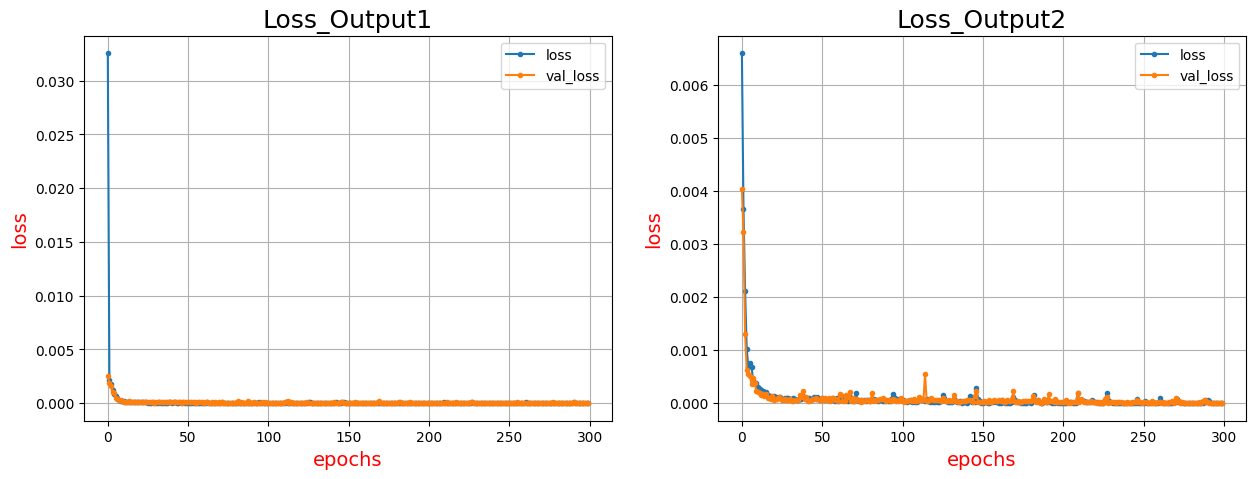

In [13]:
# 損失関数
# Figureを追加
fig = plt.figure(figsize = (15, 5))

# Output1 ====================================================================
# 1×2 の1枚目に描画する
loss_graph1 = fig.add_subplot(1, 2, 1)

# x,yに要素追加
loss1 = history.history['output1_loss']
val_loss1 = history.history['val_output1_loss']
epochs1 = len(loss1)

# グラフ設定
loss_graph1.plot(range(epochs), loss1, marker='.', label='loss')
loss_graph1.plot(range(epochs), val_loss1, marker='.', label='val_loss')
loss_graph1.set_title("Loss_Output1", size = 18)
loss_graph1.legend(loc='best')
loss_graph1.grid()
loss_graph1.set_xlabel("epochs", size = 14, color = "r")
loss_graph1.set_ylabel("loss", size = 14, color = "r")

#==============================================================================
# Output2 ====================================================================
# 1×2 の2枚目に描画する
loss_graph2 = fig.add_subplot(1, 2, 2)

# x,yに要素追加
loss2 = history.history['output2_loss']
val_loss2 = history.history['val_output2_loss']
epochs2 = len(loss2)

# グラフ設定
loss_graph2.plot(range(epochs), loss2, marker='.', label='loss')
loss_graph2.plot(range(epochs), val_loss2, marker='.', label='val_loss')
loss_graph2.set_title("Loss_Output2", size = 18)
loss_graph2.legend(loc='best')
loss_graph2.grid()
loss_graph2.set_xlabel("epochs", size = 14, color = "r")
loss_graph2.set_ylabel("loss", size = 14, color = "r")
#==============================================================

Text(0, 0.5, 'predicted_data')

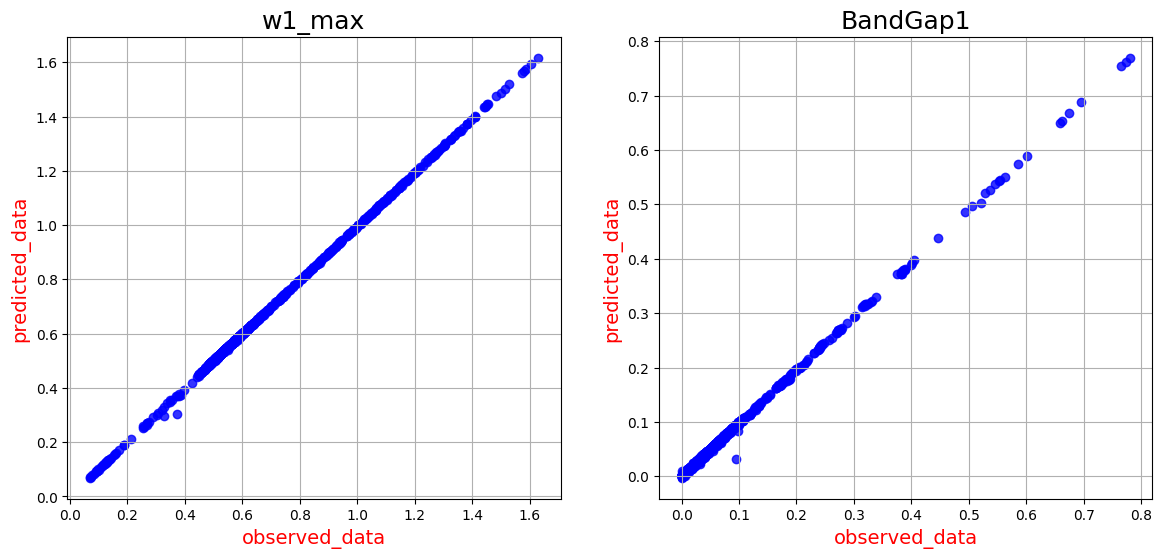

In [14]:
# Observed-Predicted Plot
# Figureを追加
fig = plt.figure(figsize = (14, 6))

# Output1 ====================================================================
# 1×2 の1枚目に描画する
yy1 = fig.add_subplot(1, 2, 1)

yy1.scatter(y_test.iloc[:, 0], pred1, c='blue', alpha=0.8)

# グラフ設定
yy1.set_title("w1_max", size = 18)
yy1.grid()
yy1.set_xlabel("observed_data", size = 14, color = "r")
yy1.set_ylabel("predicted_data", size = 14, color = "r")

# Output2 ====================================================================
# 1×2 の2枚目に描画する
yy2 = fig.add_subplot(1, 2, 2)

yy2.scatter(y_test.iloc[:, 1], pred2, c='blue', alpha=0.8)

# グラフ設定
yy2.set_title("BandGap1", size = 18)
yy2.grid()
yy2.set_xlabel("observed_data", size = 14, color = "r")
yy2.set_ylabel("predicted_data", size = 14, color = "r")

## 6. NSGA-II実装
参考記事
- [多目的最適化問題のNSGA-Ⅱを勉強したの整理しました](https://qiita.com/DS27/items/025a52b26a9f2471e67c)
- [多目的最適化問題のNSGA-Ⅱを実装してみた](https://qiita.com/DS27/items/dfedcad7ff48f09933a2)
- [多目的最適化](https://darden.hatenablog.com/entry/2017/05/26/234845)


In [15]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.5 MB/s eta 0:00:00


In [16]:
# 必要なライブラリーのインポート
import array
import random
import json

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

In [26]:
# 所望値yを定数で設定
target_w11_max = 1.5
target_BandGap1 = 0.7

In [34]:
# DEAPの設定
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()
NDIM = 3
BOUND_LOW = [0, 0, 0.01]
BOUND_UP = [3, 3, 0.999]

# 遺伝子生成の関数
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [35]:
# 目的関数(obj = (g(x1, x2, x3) - y)^2)
def evaluate(individual):
    C_center, rho_center, f = individual
    inputs = np.array([[C_center, rho_center, f]])
    predicted = model(inputs)
    obj_1 = np.sum((predicted[0] - target_w11_max) ** 2)
    obj_2 = np.sum((predicted[1] - target_BandGap1) ** 2)
    return obj_1, obj_2

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) # 遺伝子生成
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float) # 個体生成
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # 個体群生成
toolbox.register("evaluate", evaluate) # 個体の評価
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0) # 交叉
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM) # 突然変異
toolbox.register("select", tools.selNSGA2) # NSGA-IIを選択

In [36]:
def main():
    random.seed(64)
    MU = 100 # 個体数
    NGEN = 100 # 繰り返し世代数
    CXPB = 0.9 # 交叉率

    # 世代ループ中のログに何を出力するかの設定
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    # 第一世代の生成
    pop = toolbox.population(n=MU)
    pop_init = pop[:]
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # 最適計算の実行
    for gen in range(1, NGEN):
        # 子母集団生成
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # 交叉と突然変異
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            # 交叉させる個体を選択
            if random.random() <= CXPB:
                # 交叉
                toolbox.mate(ind1, ind2)

            # 突然変異
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)

            # 交叉と突然変異させた個体は適応度を削除する
            del ind1.fitness.values, ind2.fitness.values

        # 適応度を削除した個体について適応度の再評価を行う
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # 次世代を選択
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    # 最終世代のハイパーボリュームを出力
    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, pop_init, logbook

if __name__ == "__main__":
    pop, pop_init, stats = main()

gen	evals	std	min                            	avg	max                    
0  	100  	   	[4.62070238e-06 1.29845306e-01]	   	[1.91492295 0.83986729]
1  	100  	   	[1.53158260e-06 9.65275988e-02]	   	[1.91492295 0.53366053]
2  	100  	   	[1.53158260e-06 9.62254703e-02]	   	[1.91492295 0.50348204]
3  	100  	   	[1.60817081e-07 5.17612216e-06]	   	[1.85287607 0.50151849]
4  	100  	   	[1.60817081e-07 5.17612216e-06]	   	[1.8010453  0.49983883]
5  	100  	   	[1.60817081e-07 5.17612216e-06]	   	[1.65083981 0.49983883]
6  	100  	   	[1.44475109e-07 5.17612216e-06]	   	[1.29532838 0.49983883]
7  	100  	   	[1.44475109e-07 6.76286405e-08]	   	[1.29532838 0.49983883]
8  	100  	   	[1.44475109e-07 6.76286405e-08]	   	[1.01086164 0.50002748]
9  	100  	   	[1.44475109e-07 6.76286405e-08]	   	[0.99310291 0.49983883]
10 	100  	   	[4.41947954e-08 6.76286405e-08]	   	[0.99310291 0.49983883]
11 	100  	   	[4.41947954e-08 6.76286405e-08]	   	[0.99310291 0.49983883]
12 	100  	   	[4.41947954e-08 6.762864

In [28]:
# C_center, rho_center, fが求めたい入力パラメータで、それぞれ設定した目的関数の値を（）内に出力
for i in range(len(pop)):
  print("{} → C_center：{:.4f}, rho_center：{:.4f}, f：{:.4f}, （{}, {}）".format(i, pop[i][0], pop[i][1], pop[i][2], fitnesses[i][0], fitnesses[i][1]))

0 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
1 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
2 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
3 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
4 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
5 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
6 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
7 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
8 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
9 → C_center：2.2104, rho_center：0.1285, f：0.9958, （3.552713678800501e-13, 0.00027151472750119865）
10 → C_center：2.2104

 設定したそれぞれの目的関数が最適化されていることがわかる。

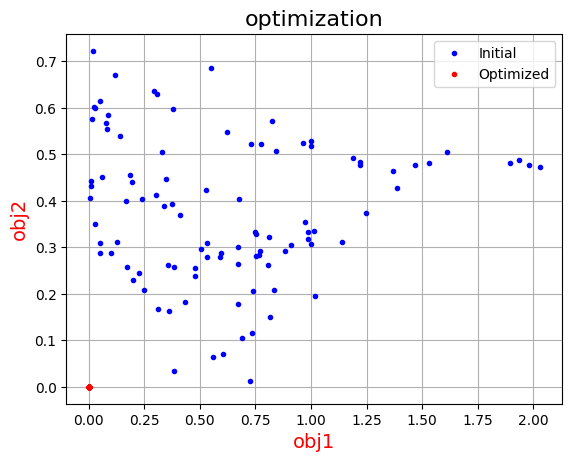

In [23]:
# x軸に目的関数1、y軸に目的関数2、初期値を青点、最適化後を赤点としてプロット
fitnesses_init = np.array([list(pop_init[i].fitness.values) for i in range(len(pop_init))])
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
plt.plot(fitnesses_init[:,0], fitnesses_init[:,1], "b.", label="Initial")
plt.plot(fitnesses[:,0], fitnesses[:,1], "r.", label="Optimized" )
plt.legend(loc="upper right")
plt.title("optimization", fontsize=16)
plt.xlabel("obj1", fontsize=14, color="red")
plt.ylabel("obj2", fontsize=14, color="red")
plt.grid(True)

### 理想点に着地しない場合

In [38]:
# 所望値yを定数で設定（両方を満たせない形で）
target_w11_max = 0.3
target_BandGap1 = 0.7

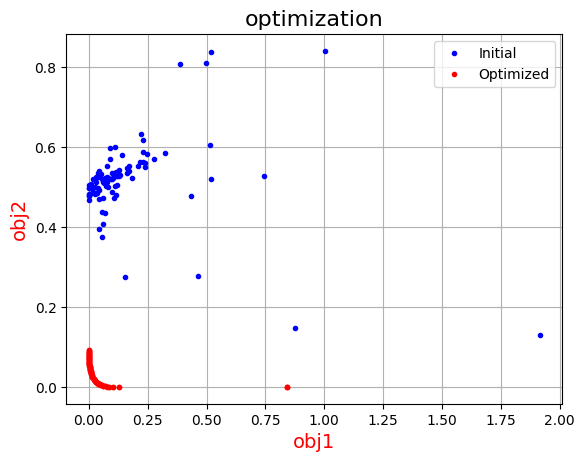

In [37]:
# x軸に目的関数1、y軸に目的関数2、初期値を青点、最適化後を赤点としてプロット
fitnesses_init = np.array([list(pop_init[i].fitness.values) for i in range(len(pop_init))])
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
plt.plot(fitnesses_init[:,0], fitnesses_init[:,1], "b.", label="Initial")
plt.plot(fitnesses[:,0], fitnesses[:,1], "r.", label="Optimized" )
plt.legend(loc="upper right")
plt.title("optimization", fontsize=16)
plt.xlabel("obj1", fontsize=14, color="red")
plt.ylabel("obj2", fontsize=14, color="red")
plt.grid(True)

可能な限り良い解であるパレート解をプロットしていることがわかる。